<a href="https://colab.research.google.com/github/iamviji/project/blob/master/PostMidTerm/misc/TF2_Autoencoder_BER_Comparision_BPSK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special

np.random.seed(42)
tf.random.set_seed(42)

In [153]:
# Parameters
SAMPLE_SIZE = 100000
k = 1
n = 1 # complex channel uses
M = 2**k
TRAINING_SNR_PER_BIT = 7

In [154]:
# Generate Training Data
x = tf.random.uniform(shape=[SAMPLE_SIZE], minval=0, maxval=M, dtype=tf.int64)
input_msg = tf.one_hot(x, M)

In [155]:
def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB] to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(ebno)
    return noise_std

In [156]:
noise_std = EbNo_to_noise(TRAINING_SNR_PER_BIT)

# Some custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2*n]))
channel_layer = keras.layers.Lambda(lambda x: 
                    x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

encoder = keras.models.Sequential([
keras.layers.InputLayer(input_shape=[2**k]),
keras.layers.Dense(M, activation="relu"),
keras.layers.Dense(2*n, activation=None),
shape_layer,
norm_layer])

channel = keras.models.Sequential([channel_layer])

decoder = keras.models.Sequential([keras.layers.InputLayer(input_shape=[2,n]),
shape_layer2,
keras.layers.Dense(M, activation="relu"),
keras.layers.Dense(M, activation="softmax")
])

autoencoder = keras.models.Sequential([encoder, channel, decoder])

In [157]:
def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

In [158]:
autoencoder.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=[B_Ber])

In [159]:
history = autoencoder.fit(input_msg, input_msg, epochs=5, batch_size=100)

Epoch 1/5
1000/1000 [==============================] - 2s 1ms/step - loss: 0.7362 - B_Ber: 0.5562
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3723 - B_Ber: 0.1856
Epoch 3/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0079 - B_Ber: 7.7019e-04
Epoch 4/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0040 - B_Ber: 7.6659e-04
Epoch 5/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0030 - B_Ber: 8.6751e-04


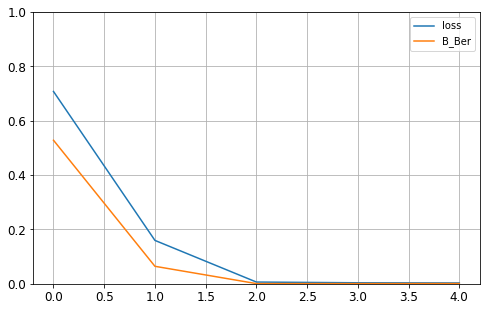

In [160]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [161]:
# Test coding
inp = np.eye(2**k, dtype=int)
coding = encoder.predict(inp)

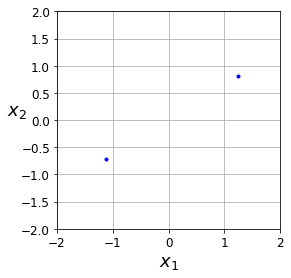

In [162]:
# for n=1 data
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:, 1], "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.gca().set_ylim(-2, 2)
plt.gca().set_xlim(-2, 2)
plt.show()

In [163]:
# test msg sequence
test_msg = np.random.randint(M, size=150000)
one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(M)])
data_one_h = one_hot_encoder.fit_transform(test_msg.reshape(-1,1))

In [164]:
def Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 30)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = encoder.predict(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = decoder.predict(rcvd_word)
        bber_vec[db] = B_Ber(data, dcoded_msg)     
    return (snr_range, bber_vec) 

In [165]:
bber_data = Test_AE(data_one_h)

In [166]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

In [167]:
import numpy as np #for numerical computing
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
import math

#EbN0dBs = np.arange(start=0,stop = 15, step = 1)
EbN0dBs = ebnodbs
BPSK_BER_theory = 0.5*erfc(np.sqrt(10**(EbN0dBs/10)))
M=4
#QAM_BER_theory = 2*(1-np.sqrt(1/M))*erfc(np.sqrt(10**(EbN0dBs/10)))
QAM_BER_theory = erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
QPSK_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
M=8
PSK_8_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
QAM_8_BER_theory = 2*erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
M=16
PSK_16_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
QAM_16_BER_theory = 2*erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
M=32
PSK_32_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
print (ebnodbs)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


In [168]:
sim_itpp_psk_4 = [0.1582, 0.14571333333333333, 0.13089, 0.11711333333333333, 0.10434333333333333, 0.08994, 0.07872, 0.06783666666666667, 0.056606666666666666, 0.04643333333333333, 0.03788333333333333, 0.02977, 0.022873333333333332, 0.017086666666666667, 0.012683333333333333, 0.009173333333333334, 0.00616, 0.00397, 0.00243, 0.00141, 0.00082, 0.00042, 0.00022, 6.333333333333333e-05, 4.6666666666666665e-05, 3.3333333333333333e-06, 3.3333333333333333e-06, 6.666666666666667e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
print (len(sim_itpp_psk_4))
print (len (ebnodbs))
sim_itpp_psk_4_filtered = []
for i in range(0, len(ebnodbs)):
    sim_itpp_psk_4_filtered.append (sim_itpp_psk_4[i*2])
print (sim_itpp_psk_4_filtered)

60
16
[0.1582, 0.13089, 0.10434333333333333, 0.07872, 0.056606666666666666, 0.03788333333333333, 0.022873333333333332, 0.012683333333333333, 0.00616, 0.00243, 0.00082, 0.00022, 4.6666666666666665e-05, 3.3333333333333333e-06, 0.0, 0.0]


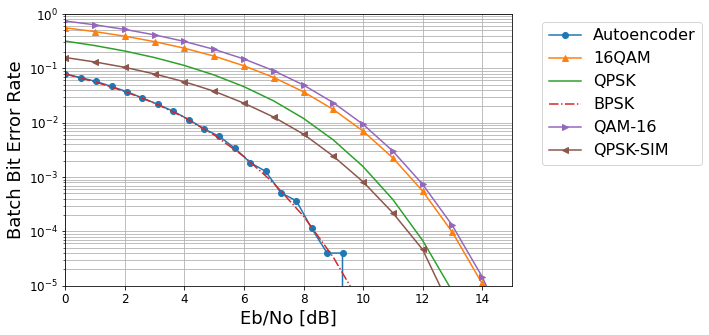

In [169]:
fig = plt.figure(figsize=(8, 5))
# Plot Autoencoder
plt.semilogy(bber_data[0], bber_data[1], 'o-')
# Plot approx 16 QAM
ebnodbs = np.linspace(0,15,16)
plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '^-');
plt.semilogy(ebnodbs, QPSK_BER_theory, '-');
plt.semilogy(ebnodbs, BPSK_BER_theory, '-.');
plt.semilogy(ebnodbs, QAM_16_BER_theory, '->');
plt.semilogy(ebnodbs, sim_itpp_psk_4_filtered, '-<');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Bit Error Rate", fontsize=18, rotation=90)
plt.xlabel("Eb/No [dB]", fontsize=18)
plt.legend(['Autoencoder', '16QAM', 'QPSK', 'BPSK', 'QAM-16', 'QPSK-SIM'], prop={'size': 16},bbox_to_anchor=(1.05, 1), loc='upper left');
plt.grid(True, which="both")

In [170]:
print (QPSK_BER_theory)

[3.17310508e-01 2.61854594e-01 2.08057274e-01 1.57791744e-01
 1.12990603e-01 7.53579763e-02 4.60142778e-02 2.51740662e-02
 1.20087728e-02 4.82662084e-03 1.56540226e-03 3.87970944e-04
 6.86052477e-05 7.93849679e-06 5.39029623e-07 1.87220800e-08]
